In [1]:
import os
import numpy as np
import math
import cv2
import glob
from  matplotlib import pyplot as plt
%matplotlib inline
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import image
import tensorflow as tf
print(tf.__version__)
'''
https://www.tensorflow.org/tutorials/load_data/images
從磁碟機讀取 image dataset方法
'''
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import optimizers

Using TensorFlow backend.


2.1.0


In [35]:
# dataset
train_dir=r'C:\Users\user\chou_paper_data\flower_data\train'  # training data
predict_dir=r'C:\Users\user\chou_paper_data\flower_data\valid'  # testing data
test_dir=r'C:\Users\user\chou_paper_data\flower_data\test'  # test data
batch_size=32
img_size=(227, 227)
freeze_layers_number=0
classes=sorted([o for o in os.listdir(train_dir)])  # 根据文件名分类

import requests
import json
file_location=r'C:\Users\user\chou_paper_data\flower_data\cat_to_name.json'
f=open(file_location)
class_names=json.loads(f.read())
class_names = {int(k):v for k,v in class_names.items()}

nb_train_samples = len(glob.glob(train_dir + '/*/*.*'))  # number of training data
nb_predict_samples = len(glob.glob(predict_dir + '/*/*.*'))  # number of validing data
nb_test_samples = len(glob.glob(test_dir + '/*.*'))  # number of test data
print(nb_train_samples,nb_predict_samples,nb_test_samples,'total=',nb_train_samples+nb_predict_samples+nb_test_samples)

6552 818 819 total= 8189


In [36]:
def preprocessing(inputdata):
    inputdata=cv2.resize(inputdata,img_size)
    renorm_image = np.reshape(inputdata,(inputdata.shape[0]*inputdata.shape[1],3))
    #Before applying PCA you must normalize the data in each column separately as we will be applying PCA column-wise
    mean = np.mean(renorm_image, axis=0) #computing the mean
    std = np.std(renorm_image, axis=0) #computing the standard deviation
    renorm_image = renorm_image.astype('float32') #we change the datatpe so as to avoid any warnings or errors
    renorm_image -= np.mean(renorm_image, axis=0)
    renorm_image /= np.std(renorm_image, axis=0) # next we normalize the data using the 2 columns
    cov = np.cov(renorm_image, rowvar=False) #finding the co-variance matrix for computing the eigen values and eigen vectors.
    lambdas, p = np.linalg.eig(cov) # finding the eigen values lambdas and the vectors p of the covarince matrix
    alphas = np.random.normal(0, 0.1, 3) # aplha here is the gaussian random no. generated
    delta = np.dot(p, alphas*lambdas) #delta here represents the value which will be added to the re_norm image
    pca_augmentation_version_renorm_image = renorm_image + delta #forming augmented normalised image
    pca_color_image = pca_augmentation_version_renorm_image * std + mean #de-normalising the image
    pca_color_image = np.maximum(np.minimum(pca_color_image, 255), 0).astype('uint8') # necessary conditions which need to be checked
    pca_color_image=np.ravel(pca_color_image).reshape((inputdata.shape[0],inputdata.shape[1],3))
    outputdata=cv2.normalize(pca_color_image.astype('float'), None, 0.0, 1.0, cv2.NORM_MINMAX)
    return outputdata.astype(np.float64)

In [37]:
train_datagen = ImageDataGenerator(
    #rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2,
    preprocessing_function = preprocessing) # set validation split

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
    train_dir, # same directory as training data
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation') # set as validation data

pred_datagen=ImageDataGenerator(
    preprocessing_function=preprocessing)

pred_generator = pred_datagen.flow_from_directory(
    predict_dir, # same directory as training data
    target_size=img_size,
    batch_size=1,
    class_mode='categorical', 
    shuffle=False)

filenames=pred_generator.filenames
nb_samples=len(filenames)

Found 5283 images belonging to 102 classes.
Found 1269 images belonging to 102 classes.
Found 818 images belonging to 102 classes.


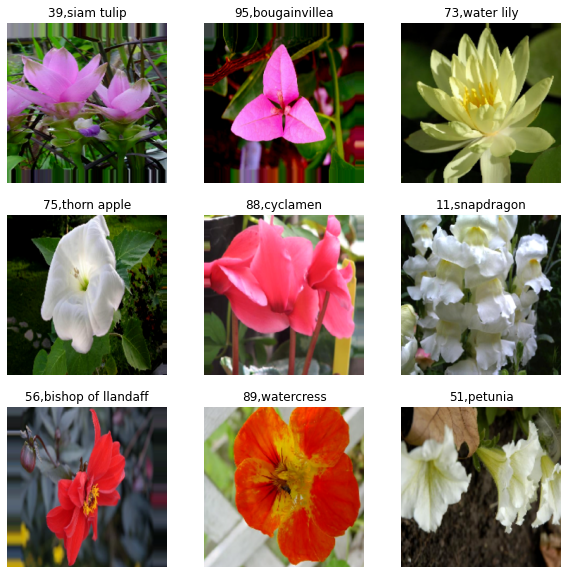

In [28]:
from scipy import ndimage
import scipy.interpolate
datas,labels = train_generator.next()
true_labels=[np.argmax(labels)for labels in labels]
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(datas[i])
    plt.title(classes[true_labels[i]]+','+class_names[int(classes[true_labels[i]])])
    plt.axis("off")

In [9]:
'''
ref:经典CNN之：AlexNet介绍
https://blog.csdn.net/daydayup_668819/article/details/79744095

ref:【深度学习理论3】ALexNet模型的详解
https://blog.csdn.net/maweifei/article/details/53117830

ref:batch norm、relu、dropout 等的相对顺序和BN、dropout的几个问题和思考
https://blog.csdn.net/m0_37870649/article/details/82025238
'''
def AlexNet(input_shape):
    X_input = Input(input_shape)
    X = Conv2D(96,(11,11),strides=(4,4),name="conv0")(X_input)
    X = Activation('relu')(X)
    X = MaxPooling2D((3,3),strides = 2,name = 'max0')(X)
    X = BatchNormalization(axis = 3 , name = "bn0")(X)
    
    X = Conv2D(256,(5,5),padding = 'same' , name = 'conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3,3),strides = 2,name = 'max1')(X)
    X = BatchNormalization(axis = 3 ,name='bn1')(X)

    X = Conv2D(384, (3,3) , padding = 'same' , name='conv2')(X)
    X = Activation('relu')(X)
    
    X = Conv2D(384, (3,3) , padding = 'same' , name='conv3')(X)
    X = Activation('relu')(X)
    
    X = Conv2D(256, (3,3) , padding = 'same' , name='conv4')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3,3),strides = 2,name = 'max2')(X)
    
    X = Flatten()(X)
    
    X = Dense(4096, activation = 'relu', name = "fc0")(X)
    X = Dropout(0.5)(X)
    
    X = Dense(4096, activation = 'relu', name = 'fc1')(X)
    X = Dropout(0.5)(X)
    
    X = Dense(len(classes),activation='softmax', name = 'softmax')(X)
    model = Model(inputs = X_input, outputs = X, name='AlexNet')
    return model

In [10]:
model=AlexNet((227,227,3))
model.summary()

Model: "AlexNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 227, 227, 3)]     0         
_________________________________________________________________
conv0 (Conv2D)               (None, 55, 55, 96)        34944     
_________________________________________________________________
activation_5 (Activation)    (None, 55, 55, 96)        0         
_________________________________________________________________
max0 (MaxPooling2D)          (None, 27, 27, 96)        0         
_________________________________________________________________
bn0 (BatchNormalization)     (None, 27, 27, 96)        384       
_________________________________________________________________
conv1 (Conv2D)               (None, 27, 27, 256)       614656    
_________________________________________________________________
activation_6 (Activation)    (None, 27, 27, 256)       0   

In [11]:
num_epoch=100

optimizer=tf.keras.optimizers.SGD(learning_rate=1e-3, momentum=0.5, nesterov=True, name='SGD')

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
early_stopping = EarlyStopping(verbose=1, patience=5, min_delta=1e-4, monitor='val_accuracy')
callbacks = [early_stopping]

history=model.fit(train_generator,
                  steps_per_epoch=None,
                  validation_data=validation_generator,
                  validation_steps=None,
                  epochs=num_epoch,
                  callbacks=callbacks)
 
print('Training is finished!')

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 166 steps, validate for 40 steps
Epoch 1/100
166/166 [==============================] - 196s 1s/step - loss: 4.5773 - accuracy: 0.0316 - val_loss: 4.5466 - val_accuracy: 0.0268
Epoch 2/100
166/166 [==============================] - 192s 1s/step - loss: 4.2929 - accuracy: 0.0632 - val_loss: 4.3023 - val_accuracy: 0.0583
Epoch 3/100
166/166 [==============================] - 194s 1s/step - loss: 4.0618 - accuracy: 0.0852 - val_loss: 3.8904 - val_accuracy: 0.1418
Epoch 4/100
166/166 [==============================] - 189s 1s/step - loss: 3.8732 - accuracy: 0.1015 - val_loss: 3.6196 - val_accuracy: 0.1639
Epoch 5/100
166/166 [==============================] - 185s 1s/step - loss: 3.7720 - accuracy: 0.1119 - val_loss: 3.5287 - val_accuracy: 0.1734
Epoch 6/100
166/166 [==============================] - 188s 1s/step - loss: 3.6502 - accuracy: 0.1346 - val_loss: 3.3929 - val_accuracy: 0.2096
Epoch 7/100
166/166 [======================

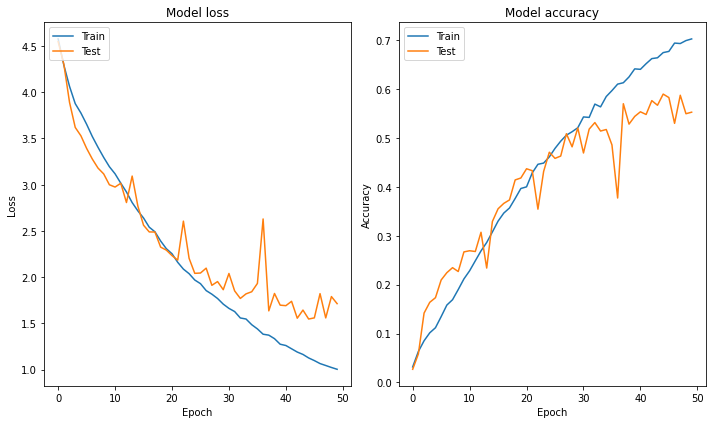

In [12]:
fig, (ax1, ax2) = plt.subplots(figsize=(10,6), ncols=2)
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss']) 
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch')
ax1.legend(['Train', 'Test'], loc='upper left')
ax1.set_title(f'Model loss')
ax2.plot(history.history['accuracy'])
ax2.plot(history.history['val_accuracy'])
ax2.set_ylabel('Accuracy')
ax2.set_xlabel('Epoch')
ax2.legend(['Train', 'Test'], loc='upper left')
ax2.set_title(f'Model accuracy')
plt.tight_layout()
plt.savefig(r'C:\Users\user\fc_alexnet_hitroy.jpg')

In [6]:
'''
model.save('fc_alexnet.h5')
'''
from tensorflow.keras.models import load_model
model = load_model(r'C:\Users\user\fc_alexnet.h5')

10:99.85%
35:0.08%
29:0.05%
22:0.02%
25:0.00%


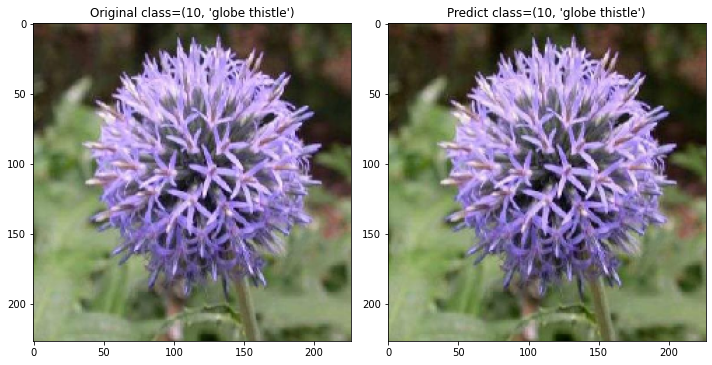

In [38]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
file_path=r'C:\Users\user\chou_paper_data\flower_data\valid'
label_path=r'10'
image_path=r'image_07094.jpg'
orig_image=image.load_img(file_path+'\\'+label_path+'\\'+image_path, target_size=img_size)
test_image=image.img_to_array(orig_image)
test_image=preprocessing(test_image)
pred_image = test_image[None]
y = model.predict(pred_image)

for i in np.argsort(y[0])[::-1][:5]:
    print('{}:{:.2f}%'.format(classes[i], y[0][i] * 100))

predict_label=classes[np.argsort(y[0])[::-1][0]]

fig, (ax1, ax2) = plt.subplots(figsize=(10,10), ncols=2)
ax1.imshow(orig_image)
ax1.grid(False)
ax1.set_title(f'Original class={int(label_path),class_names[int(label_path)]}')
ax2.imshow(test_image)
ax2.grid(False)
ax2.set_title(f'Predict class={int(predict_label),class_names[int(predict_label)]}')
plt.tight_layout()
plt.show()

In [39]:
predict=model.predict(pred_generator,steps=nb_samples)
pred_classes=sorted([o for o in os.listdir(predict_dir)])
y_true=[]
for i in range(nb_samples):
    y_true.append(pred_classes[pred_generator.classes[i]])

y_pred=[]
for j in range(nb_samples):
    predict_label=classes[np.argsort(predict[j])[::-1][0]]
    y_pred.append(predict_label)
    
from sklearn.metrics import accuracy_score
accuracy_score(y_true, y_pred)

0.5709046454767727

In [43]:
import time
start=time.time()
num=0
acc=0
for root, dirs, files in os.walk(r'C:\Users\User\chou_paper_data\flower_data\valid',topdown=False):
    for name in files:
        orig_image=image.load_img(os.path.join(root,name), target_size=img_size)
        test_image=image.img_to_array(orig_image)
        test_image=preprocessing(test_image)
        pred_image=test_image[None]
        y=model.predict(pred_image)
        predict_label=classes[np.argsort(y[0])[::-1][0]]

        file=os.path.basename(os.path.dirname(os.path.dirname(root)))
        subfile_l1=os.path.basename(os.path.dirname(root))#train, test, validation
        subfile_l2=os.path.basename(root)#label
 
        fig, (ax1, ax2) = plt.subplots(figsize=(10,10), ncols=2)
        ax1.imshow(orig_image)
        ax1.set_title(f'Original Image{int(subfile_l2), class_names[int(subfile_l2)]}')
        ax2.imshow(test_image)
        ax2.set_title(f'Predict{int(predict_label), class_names[int(predict_label)]}')
        plt.tight_layout()
        
        write_path=os.path.abspath(os.path.join(root, "../.."))+'_predict fc_alexnet'
        
        if subfile_l2==predict_label:
            if os.path.exists(write_path)==False:
                os.mkdir(write_path)
            if os.path.exists(write_path+'\\'+subfile_l1+'_true')==False:
                os.mkdir(write_path+'\\'+subfile_l1+'_true')
            if os.path.exists(write_path+'\\'+subfile_l1+'_true'+'\\'+subfile_l2)==False:
                os.mkdir(write_path+'\\'+subfile_l1+'_true'+'\\'+subfile_l2)

            plt.savefig(write_path+'\\'+subfile_l1+'_true'+'\\'+subfile_l2+'\\'+name)
            acc+=1
        if subfile_l2!=predict_label:
            if os.path.exists(write_path)==False:
                os.mkdir(write_path)
            if os.path.exists(write_path+'\\'+subfile_l1+'_false')==False:
                os.mkdir(write_path+'\\'+subfile_l1+'_false')
            if os.path.exists(write_path+'\\'+subfile_l1+'_false'+'\\'+subfile_l2)==False:
                os.mkdir(write_path+'\\'+subfile_l1+'_false'+'\\'+subfile_l2)
            
            plt.savefig(write_path+'\\'+subfile_l1+'_false'+'\\'+subfile_l2+'\\'+name)
        plt.close()
        num+=1
end=time.time()
print('accuracy=',acc/num)
print(end-start)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

accuracy= 0.5745721271393643
171.3093192577362
